In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats 

In [7]:
##reading transition probability data

file_path = "transition_0_1_neg.txt"
with open(file_path, 'r') as f:
    lines = f.readlines()

data = [list(map(float, line.strip().split())) for line in lines if line.strip()]
split_index = len(data) // 2
voltage_rows = data[:split_index]
prob_rows = data[split_index:]

volts_01 = np.array([val for row in voltage_rows for val in row])
probs_01= np.array([val for row in prob_rows for val in row])

file_path = "transition_1_0_pos.txt"

with open(file_path, 'r') as f:
    lines = f.readlines()

data = [list(map(float, line.strip().split())) for line in lines if line.strip()]
split_index = len(data) // 2
voltage_rows = data[:split_index]
prob_rows = data[split_index:]

volts_10 = np.array([val for row in voltage_rows for val in row])
probs_10 = np.array([val for row in prob_rows for val in row])

# sigmoid fitting and plotting



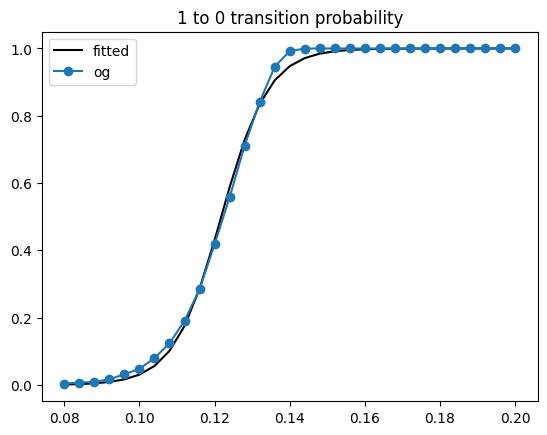

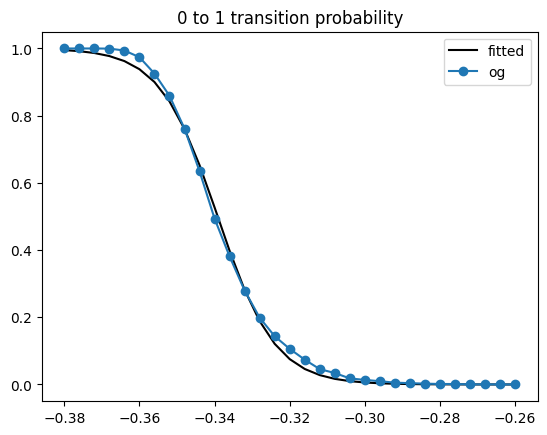

In [18]:
#general sigmoid function
def sig_fit(x, x0, k):
    return 1 / (1+np.exp(-k*(x-x0)))


#general guess for curve fit
x0_guess = np.median(volts_10)
k_guess = 10 

p0 = [x0_guess, k_guess]
volts_fit10, ___ = curve_fit(sig_fit, volts_10, probs_10, p0=p0)
true_x_10, true_k_1 = volts_fit10 #true  x0, k values

x0_guess = np.median(volts_01)
p0 = [x0_guess, k_guess]

volts_fit01, ___ = curve_fit(sig_fit, volts_01, probs_01, p0=p0)
true_x_01 , true_k_0 = volts_fit01

plt.plot(volts_10, sig_fit(volts_10, true_x_10, true_k_1), 'k', label = 'fitted')
plt.plot(volts_10, probs_10, 'o-', label = 'og')
plt.title("1 to 0 transition probability")
plt.legend()
plt.show()

plt.plot(volts_01, sig_fit(volts_01, true_x_01, true_k_0), 'k', label = 'fitted')
plt.plot(volts_01, probs_01, 'o-', label = 'og')
plt.title("0 to 1 transition probability")
plt.legend()
plt.show()

# reading data from mnist

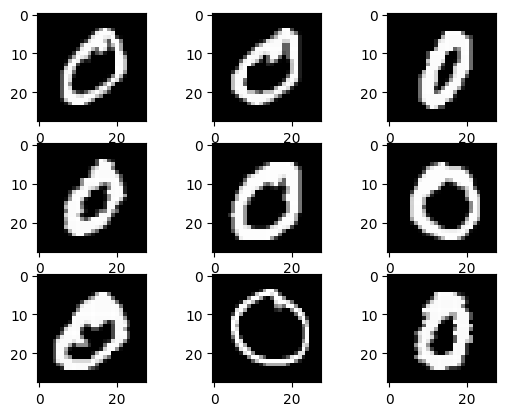

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_mask = np.isin(y_train, [0]) #0 here for only chossing images with 0
x_train0 = x_train[train_mask]
y_train = y_train[train_mask]

x_train0 = x_train0 / 255.0 #normalize so grayscale is from 0 - 1

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train0[i], cmap=plt.get_cmap('gray'))

# functions

In [36]:
# converting the images to 1D arrays, and choosing some num of images (length)
# returns array of converted 1d arrays

def to_1D(x_train, length):
    '''assumes 28x28 pixels''' 
    
    images = x_train[0:length]
    arrays1D = np.zeros((length,784))
    
    #num here extends from 0 to 783, its take the 2d array from image (j,k loop) and flattens it out to one dimension
    #also loops over each image by index i
    
    for i, image in enumerate(images):
        num = 0
        #assert image.shape(28,28)
        
        for j in range(28):
            for k in range(28):
                arrays1D[i][num] = image[j][k]
                num = num + 1

    return arrays1D



# takes pixel (gray_num) in the grayscale and returns the corresponding voltage by matching the percentile 
# in the grayscale to the same one in the voltage range

def find_matching_volt(gray_num, grayscale, volts_range):
    
    percentile = scipy.stats.percentileofscore(grayscale, gray_num)
    
    return np.percentile(volts_range, percentile)



# creates a pulse train from the image's grayscale using find_matching_volt function
def create_pulse_train(grayscale, volts_range):
    
    pulse_train = np.zeros(len(grayscale))

    for i, gray_num in enumerate(grayscale):
        pulse_train[i] = find_matching_volt(gray_num, grayscale, volts_range)
        
    return pulse_train


    
#creates a transition matrix given a pulse
#fitted_pars10 and fitted_pars01 contain the true x0 and k values for the sigmoid functions

def trans_matrix(pulse, sigfit, fitted_pars10, fitted_pars01):
    matrix = np.zeros((2,2))
    
    x0, k = fitted_pars10
    prob10 = sigfit(pulse, x0, k)

    x0, k = fitted_pars01
    prob01 = sigfit(pulse, x0, k)


    matrix[0][0] =  1 - prob01
    matrix[0][1] = prob01
    matrix[1][0] = prob10
    matrix[1][1] = 1 - prob10

    #print(f"This is the transition matrix: for pulse {pulse}: {matrix}")
    return matrix



#takes the pulse train and and creates an array of all the corresponding transition matrices using the trans_matrix() above
#then finds dot product of all transition matrices

def find_final_matrix(pulses, sigfit, fitted_pars10, fitted_pars01):
    matrices = np.zeros((len(pulses), 2, 2,))
    final_matrix = np.identity(2)
    
    for i, pulse in enumerate(pulses):
        matrices[i] = trans_matrix(pulse, sigfit, fitted_pars10, fitted_pars01)

        #dots the current transition matrix, with the previous one
        if i != 0:
            final_matrix = np.dot(final_matrix, matrices[i-1])         
    return final_matrix

# finds the steady state by finding the eigenval 1 and takingt the corresponding eigenvec and normaliziing

def find_steady_state(matrix):
    assert matrix.shape == (2, 2)
    eigenvals, eigenvecs = np.linalg.eig(matrix.T)

    #finding the index with the eigenval thats cloest to 1
    index = np.argmin(np.abs(eigenvals - 1))

    vec1 = eigenvecs[:, index]
    return vec1/np.sum(vec1)

# voltage range trimming (?)

In [32]:
#in general I am NOT confident that this is the best way to manipulate the voltage range
#we dont want 0 in the gray scale to match the lowest possible voltage, and vice versa with a grey scale of 1
#so set a min and max volt that lies in the "middle" range of the transition probability



#find volt that matches with a transition probability of 0.5 
#which is the true x0 value found in the sigmoid fitting above (true_x_10 and true_x_01)

volts_10_trim = volts_10[volts_10 < true_x_10]
volts_01_trim = volts_01[volts_01 > true_x_01]

voltage_range = np.concatenate([volts_01_trim, volts_10_trim]) #trimmed voltage range

# steady state computing for zeros

In [37]:
# create an array of 50 images of zeros 
zeros = to_1D(x_train0, 50)

for i, zero in enumerate(zeros):

    #create the pulse train
    pulsetrain = create_pulse_train(zero, voltage_range)

    #find the transition matrices, and compute the final matrix
    final_matrix = find_final_matrix(pulsetrain, sig_fit, volts_fit10, volts_fit01)

    #compute steady state
    steady_state = find_steady_state(final_matrix)

    print(f"steady state for image {i}: {steady_state}")



steady state for image 0: [0.81888166 0.18111834]
steady state for image 1: [0.76806486 0.23193514]
steady state for image 2: [0.82043127 0.17956873]
steady state for image 3: [0.7674236 0.2325764]
steady state for image 4: [0.77003738 0.22996262]
steady state for image 5: [0.7959668 0.2040332]
steady state for image 6: [0.74071548 0.25928452]
steady state for image 7: [0.87715246 0.12284754]
steady state for image 8: [0.79477105 0.20522895]
steady state for image 9: [0.82991413 0.17008587]
steady state for image 10: [0.81332621 0.18667379]
steady state for image 11: [0.78810118 0.21189882]
steady state for image 12: [0.7914782 0.2085218]
steady state for image 13: [0.80028848 0.19971152]
steady state for image 14: [0.71260853 0.28739147]
steady state for image 15: [0.85124882 0.14875118]
steady state for image 16: [0.70113043 0.29886957]
steady state for image 17: [0.69463492 0.30536508]
steady state for image 18: [0.82555377 0.17444623]
steady state for image 19: [0.7831603 0.2168397

# steady state of ones for comparison

In [45]:
#steady state for ones

(x_train1, y_train), (x_test, y_test) = mnist.load_data()

train_mask = np.isin(y_train,[1])
x_train1 = x_train[train_mask]
y_train = y_train[train_mask]

x_train1 = x_train1 / 255.0

ones = to_1D(x_train1, 50)

for l, one in enumerate(ones):
    pulsetrain = create_pulse_train(one, voltage_range)
    final_matrix = find_final_matrix(pulsetrain, sig_fit, volts_fit10, volts_fit01)
    steady_state = find_steady_state(final_matrix)
    print(f"steady for one {l}: {steady_state}")

steady for one 0: [0.92695725 0.07304275]
steady for one 1: [0.91804655 0.08195345]
steady for one 2: [0.94403295 0.05596705]
steady for one 3: [0.93928328 0.06071672]
steady for one 4: [0.92277096 0.07722904]
steady for one 5: [0.83687179 0.16312821]
steady for one 6: [0.93583549 0.06416451]
steady for one 7: [0.91438523 0.08561477]
steady for one 8: [0.91786997 0.08213003]
steady for one 9: [0.87377801 0.12622199]
steady for one 10: [0.93463305 0.06536695]
steady for one 11: [0.93235765 0.06764235]
steady for one 12: [0.8990163 0.1009837]
steady for one 13: [0.93258282 0.06741718]
steady for one 14: [0.93665887 0.06334113]
steady for one 15: [0.93253106 0.06746894]
steady for one 16: [0.90337969 0.09662031]
steady for one 17: [0.92502344 0.07497656]
steady for one 18: [0.89616163 0.10383837]
steady for one 19: [0.94629932 0.05370068]
steady for one 20: [0.91240656 0.08759344]
steady for one 21: [0.88892644 0.11107356]
steady for one 22: [0.9234143 0.0765857]
steady for one 23: [0.944